In [62]:
import pandas as pd
import os
import sys
from collections import defaultdict
from pathlib import Path
import numpy as np
import json
import ipdb
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier

hoops_dir = Path("/Users/danielfriedman/Desktop/hoops")
data_dir = hoops_dir / "data"
sys.path.append(hoops_dir.as_posix())

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 25)

from pipeline import team_metadata, score_by_score

In [2]:
seasons = [f"20{year}-{year+1}" for year in range(17, 22)]


In [3]:
## Get records by date
importlib.reload(team_metadata)
rbd = team_metadata.get_records_by_date(seasons)
rbd.tail()


,date,game_id,home,vis,home_house_wins,home_house_losses,home_road_wins,home_road_losses,vis_house_wins,vis_house_losses,vis_road_wins,vis_road_losses,home_house_games,home_road_games,home_house_win_pct,home_road_win_pct,vis_house_games,vis_road_games,vis_house_win_pct,vis_road_win_pct
5410,2022-02-08,22100818,MEM,LAC,19,9,18,9,16,13,11,15,28,27,0.678571,0.666667,29,26,0.551724,0.423077
5411,2022-02-08,22100819,NOP,HOU,11,13,10,19,8,17,7,21,24,29,0.458333,0.344828,25,28,0.32,0.25
5412,2022-02-08,22100820,DAL,DET,18,10,13,13,8,18,4,23,28,26,0.642857,0.5,26,27,0.307692,0.148148
5413,2022-02-08,22100821,DEN,NYK,14,10,15,14,13,15,11,15,24,29,0.583333,0.517241,28,26,0.464286,0.423077
5414,2022-02-17,22100464,BKN,WAS,12,14,17,11,13,14,11,15,26,28,0.461538,0.607143,27,26,0.481481,0.423077


In [4]:
## Get score by score
importlib.reload(score_by_score)
sbs = score_by_score.get_sbs(seasons)
sbs.tail()

,game_id,home,vis,time,home_score,vis_score,home_win
6,22100629,NOP,LAC,46.38,106,86,True
7,22100629,NOP,LAC,46.65,108,86,True
8,22100629,NOP,LAC,46.75,110,86,True
9,22100629,NOP,LAC,47.28,113,86,True
10,22100629,NOP,LAC,47.40,113,89,True


In [361]:
## Merge!
rbd_ = rbd.copy(deep=True)
rbd_['home_wins'] = rbd_['home_house_wins'] + rbd_['home_road_wins']
rbd_['home_losses'] = rbd_['home_house_losses'] + rbd_['home_road_losses']
rbd_['home_games'] = rbd_['home_wins'] + rbd_['home_losses']
rbd_['home_win_pct'] = rbd_['home_wins'] / (rbd_['home_wins'] + rbd_['home_losses']).replace(0, -1)
rbd_['vis_wins'] = rbd_['vis_house_wins'] + rbd_['vis_road_wins']
rbd_['vis_losses'] = rbd_['vis_house_losses'] + rbd_['vis_road_losses']
rbd_['vis_games'] = rbd_['vis_wins'] + rbd_['vis_losses']
rbd_['vis_win_pct'] = rbd_['vis_wins'] / (rbd_['vis_wins'] + rbd_['vis_losses']).replace(0, -1)
rbd_ = rbd_[['game_id', 'home', 'vis', 'home_win_pct', 'vis_win_pct', 'home_games', 'vis_games']]
m = pd.merge(left=sbs, right=rbd_, on=['game_id', 'home', 'vis'])
m['home_lead'] = m['home_score'] - m['vis_score']
# m['home_win_margin'] = m['home_wins'] - m['home_losses']
# m['vis_win_margin'] = m['vis_wins'] - m['vis_losses']
m = m.loc[(m['home_games'] >= 5) & (m['vis_games'] >=5)]
m.tail()


,game_id,home,vis,time,home_score,vis_score,home_win,mins,home_lead,home_win_pct,vis_win_pct,home_games,vis_games
630473,22100629,NOP,LAC,46.38,106,86,True,46.0,20,0.365854,0.5,41,42
630474,22100629,NOP,LAC,46.65,108,86,True,46.0,22,0.365854,0.5,41,42
630475,22100629,NOP,LAC,46.75,110,86,True,46.0,24,0.365854,0.5,41,42
630476,22100629,NOP,LAC,47.28,113,86,True,47.0,27,0.365854,0.5,41,42
630477,22100629,NOP,LAC,47.40,113,89,True,47.0,24,0.365854,0.5,41,42


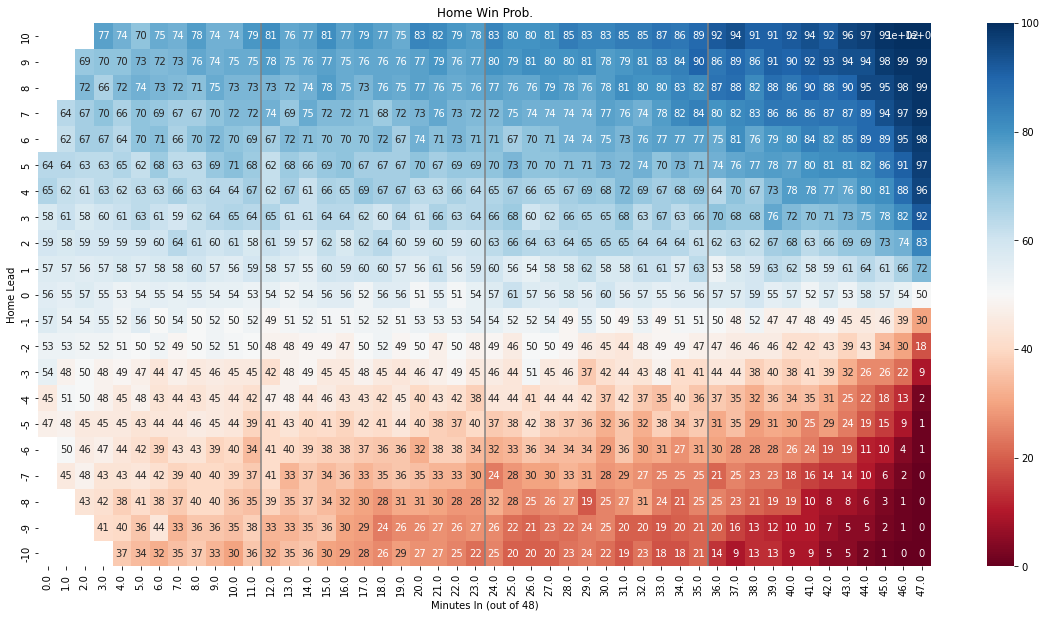

In [362]:
time_mod = 1
score_mod = 1
sbs['mins'] = sbs['time'] // time_mod
sbs['home_lead'] = (sbs['home_score'] - sbs['vis_score']) // score_mod

x = sbs.drop_duplicates(subset=['game_id', 'mins', 'home_lead']).groupby(["mins", "home_lead"]).agg({'home_win': ['count', 'mean']})['home_win'].reset_index().rename(columns={'mean':'win_pct'})
x['win_pct'] = (x['win_pct'] * 100).astype(int)
x = x.loc[x['count'] >= 100]
x = x.pivot(index='home_lead', columns='mins', values='win_pct')
x.index = np.array(list(x.index)) * score_mod
x.columns = np.array(list(x.columns)) * time_mod

fig, ax = plt.subplots(figsize=(20, 10))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
sns.heatmap(x.loc[10:-10:-1, 0:47], annot=True, cmap="RdBu")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Home Win Prob.");



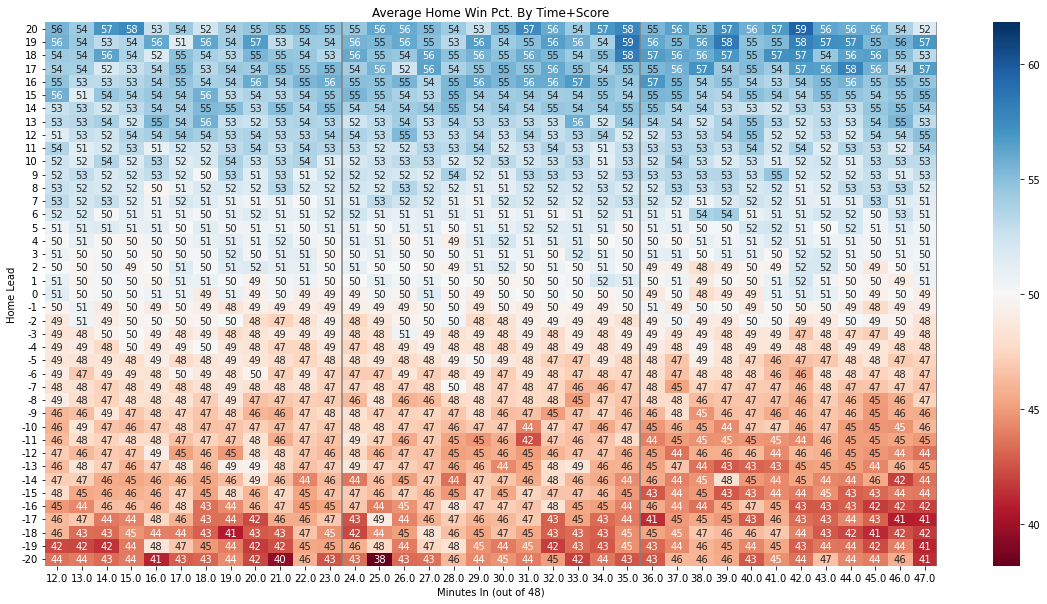

In [363]:
time_mod = 1
score_mod = 1
m['mins'] = m['time'] // time_mod
m['home_lead'] = (m['home_score'] - m['vis_score']) // score_mod

x = m.drop_duplicates(subset=['game_id', 'mins', 'home_lead']).groupby(["mins", "home_lead"])['home_win_pct'].apply(np.mean).reset_index().rename(columns={'home_win_margin':'home_win_margin'})
x = x.pivot(index='home_lead', columns='mins', values='home_win_pct')
x *= 100
x.index = np.array(list(x.index)) * score_mod
x.columns = np.array(list(x.columns)) * time_mod

fig, ax = plt.subplots(figsize=(20, 10))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
x_sub = x.loc[20:-20:-1, 12:47]
max_diff_from_500 = max(x_sub.max().max() - 50, 50-x_sub.min().min())
sns.heatmap(x_sub, annot=True, cmap="RdBu", vmin=50-max_diff_from_500, vmax=50+max_diff_from_500)
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Average Home Win Pct. By Time+Score");



# XGB

In [8]:
mod = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False
)
params = {
    'n_estimators': [50],
    'eta': [.1],
    'max_depth': [4],
    'min_child_weight': [50],
    'lambda': [1]
}
X = m[['home_win_pct', 'vis_win_pct', 'home_lead', 'mins']].to_numpy()
y = m['home_win'].astype(int).to_numpy()
grid_search = GridSearchCV(mod, params, scoring="neg_log_loss", n_jobs=-1, cv=5)
grid_result = grid_search.fit(X, y)
best_params = grid_search.best_params_ # {'eta': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 50}
mod = grid_search.best_estimator_
best_params


{'eta': 0.1,
 'lambda': 1,
 'max_depth': 4,
 'min_child_weight': 50,
 'n_estimators': 50}

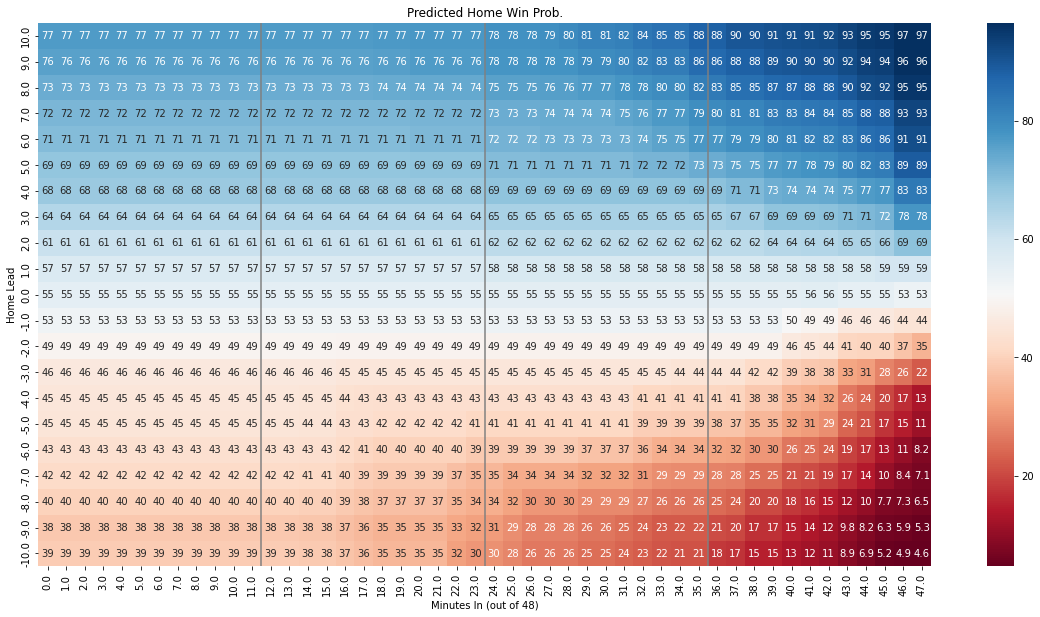

In [47]:
mins = np.arange(0, 48)
home_leads = np.arange(-10, 11)
dummy_data = pd.DataFrame(
    np.array([
        [.5]*len(mins)*len(home_leads),
        [.5]*len(mins)*len(home_leads),
        np.repeat(home_leads, len(mins)),
        np.tile(mins, len(home_leads))
    ]).T,
    columns = ['home_wpct', 'vis_wpct', 'home_lead', 'mins']
)
dummy_data['yhat'] = mod.predict_proba(dummy_data)[:,1]
panel = dummy_data.pivot(index='home_lead', columns='mins', values='yhat')

fig, ax = plt.subplots(figsize=(20, 10))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
sns.heatmap(panel[::-1]*100, annot=True, cmap="RdBu")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");



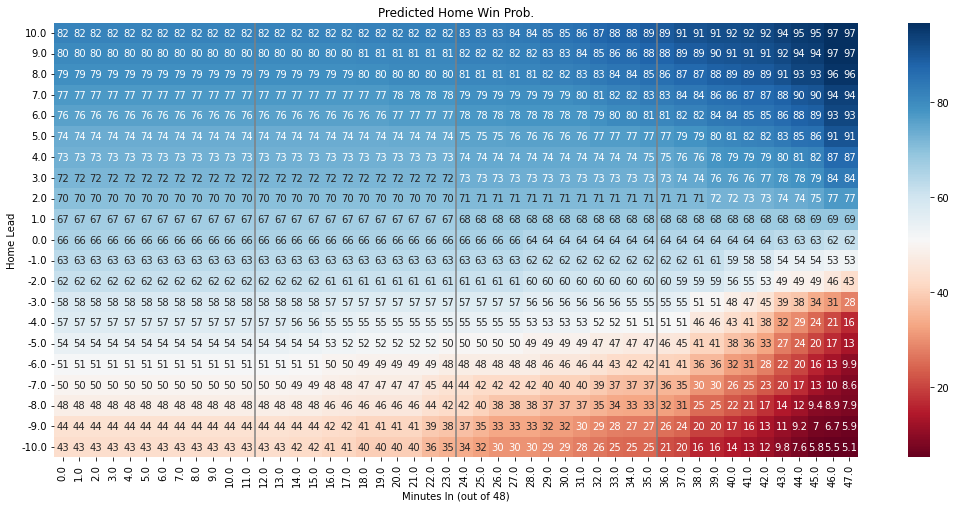

In [45]:
mins = np.arange(0, 48)
home_leads = np.arange(-10, 11)
dummy_data = pd.DataFrame(
    np.array([
        [.65]*len(mins)*len(home_leads),
        [.5]*len(mins)*len(home_leads),
        np.repeat(home_leads, len(mins)),
        np.tile(mins, len(home_leads))
    ]).T,
    columns = ['home_wpct', 'vis_wpct', 'home_lead', 'mins']
)
dummy_data['yhat'] = mod.predict_proba(dummy_data)[:,1]
panel = dummy_data.pivot(index='home_lead', columns='mins', values='yhat')

fig, ax = plt.subplots(figsize=(18, 8))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
sns.heatmap(panel[::-1]*100, annot=True, cmap="RdBu")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");



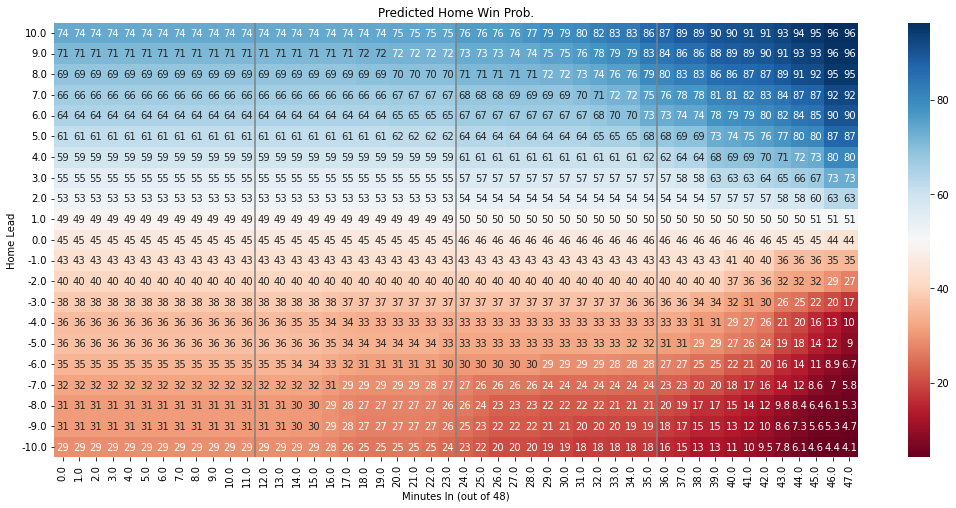

In [46]:
mins = np.arange(0, 48)
home_leads = np.arange(-10, 11)
dummy_data = pd.DataFrame(
    np.array([
        [.5]*len(mins)*len(home_leads),
        [.65]*len(mins)*len(home_leads),
        np.repeat(home_leads, len(mins)),
        np.tile(mins, len(home_leads))
    ]).T,
    columns = ['home_wpct', 'vis_wpct', 'home_lead', 'mins']
)
dummy_data['yhat'] = mod.predict_proba(dummy_data)[:,1]
panel = dummy_data.pivot(index='home_lead', columns='mins', values='yhat')

fig, ax = plt.subplots(figsize=(18, 8))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
sns.heatmap(panel[::-1]*100, annot=True, cmap="RdBu")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");



# Feature Eng

In [458]:
m.head()

,game_id,home,vis,time,home_score,vis_score,home_win,mins,home_lead,home_win_pct,vis_win_pct,home_games,vis_games,home_trend,total_points
0,21700891,SAC,LAL,0.00,0,0,False,0.0,0,0.310345,0.413793,58,58,NaN,0
1,21700891,SAC,LAL,0.30,0,2,False,0.0,-2,0.310345,0.413793,58,58,NaN,2
2,21700891,SAC,LAL,0.95,2,2,False,0.0,0,0.310345,0.413793,58,58,NaN,4
3,21700891,SAC,LAL,1.45,5,2,False,1.0,3,0.310345,0.413793,58,58,NaN,7
4,21700891,SAC,LAL,1.90,5,5,False,1.0,0,0.310345,0.413793,58,58,NaN,10


In [364]:
## Trend
trend_size = 10
m['home_trend'] = m['home_lead'] - m['home_lead'].shift(trend_size)
game_id_trend_ago = m['game_id'].shift(trend_size)
m.loc[m['game_id'] != game_id_trend_ago, 'home_trend'] = np.nan

,game_id,home,vis,time,home_score,vis_score,home_win,mins,home_lead,home_win_pct,vis_win_pct,home_games,vis_games,home_trend
0,21700891,SAC,LAL,0.00,0,0,False,0.0,0,0.310345,0.413793,58,58,NaN
1,21700891,SAC,LAL,0.30,0,2,False,0.0,-2,0.310345,0.413793,58,58,NaN
2,21700891,SAC,LAL,0.95,2,2,False,0.0,0,0.310345,0.413793,58,58,NaN
3,21700891,SAC,LAL,1.45,5,2,False,1.0,3,0.310345,0.413793,58,58,NaN
4,21700891,SAC,LAL,1.90,5,5,False,1.0,0,0.310345,0.413793,58,58,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630473,22100629,NOP,LAC,46.38,106,86,True,46.0,20,0.365854,0.5,41,42,5.0
630474,22100629,NOP,LAC,46.65,108,86,True,46.0,22,0.365854,0.5,41,42,6.0
630475,22100629,NOP,LAC,46.75,110,86,True,46.0,24,0.365854,0.5,41,42,6.0
630476,22100629,NOP,LAC,47.28,113,86,True,47.0,27,0.365854,0.5,41,42,7.0


In [472]:
## Scoring Rate
m['total_points'] = m['home_score'] + m['vis_score']
m['ppm'] = m['total_points'] / m['time']


In [484]:
mod = XGBClassifier(
    ## Objective/Eval
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    
    ## Fitting Params
    n_estimators=300,
    eta=.01,
    max_depth=5,
    reg_lambda=10,
    reg_alpha=0,
    gamma=3,
    min_child_weight=3,
    colsample_bytree=0.9
)

# X = m[['home_win_pct', 'vis_win_pct', 'home_lead', 'mins']].to_numpy()
X = m[['home_win_pct', 'vis_win_pct', 'home_lead', 'ppm', 'total_points', 'mins']].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=124)
mod.fit(X_train, y_train)
y_hat = mod.predict_proba(X_test)[:,1]
mod.score(X_test, y_test)


0.7735246663359958

0.03823657887400214


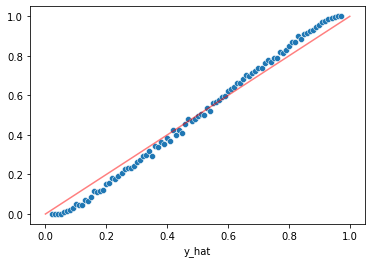

In [485]:
modulo = .01
ys = pd.DataFrame({'y':y_test, 'y_hat':y_hat}).sort_values(['y', 'y_hat'])
ybar_by_yhat = ys.groupby(ys['y_hat'] // modulo)['y'].mean()
ybar_by_yhat.index *= modulo

print(np.mean(abs(ybar_by_yhat - ybar_by_yhat.index)))
sns.scatterplot(x=ybar_by_yhat.index, y=ybar_by_yhat.values)
sns.lineplot(x=np.arange(2), y=np.arange(2), color='red', alpha=0.5);


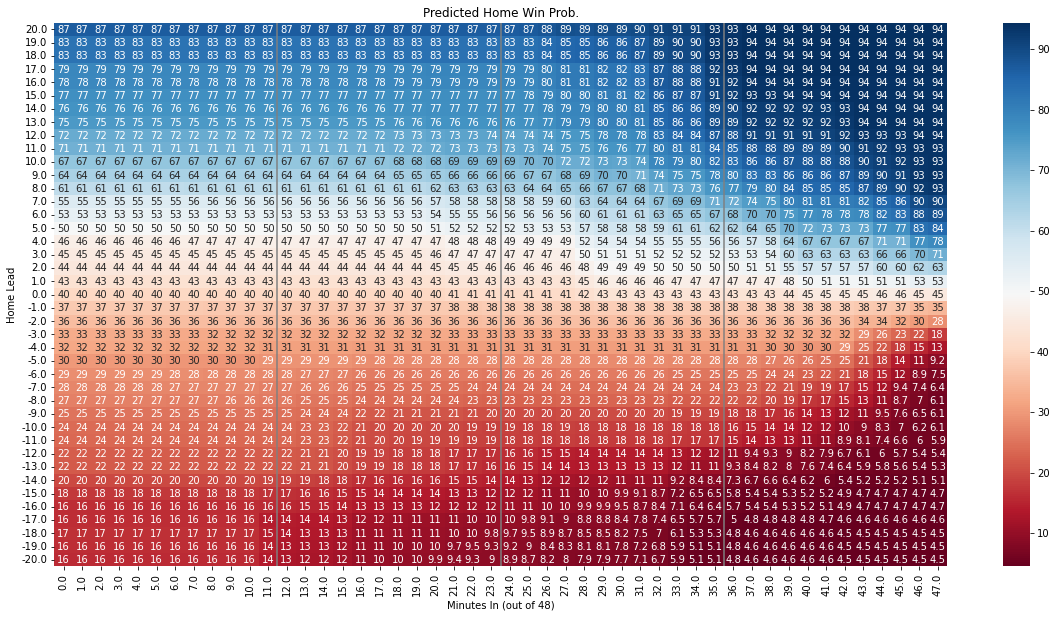

In [782]:
mins = np.arange(0, 48)
home_leads = np.arange(-20, 21)
dummy_data = pd.DataFrame(
    np.array([
        np.tile(.36, len(mins)*len(home_leads)),
        np.tile(.57, len(mins)*len(home_leads)),
        np.repeat(home_leads, len(mins)),
        np.tile(5, len(mins)*len(home_leads)),
        np.tile(5*mins, len(home_leads)),
        np.tile(mins, len(home_leads))
    ]).T,
    columns = ['home_wpct', 'vis_wpct', 'home_lead', 'ppm', 'total_points', 'mins']
)
dummy_data['yhat'] = mod.predict_proba(dummy_data)[:,1]
panel = dummy_data.pivot(index='home_lead', columns='mins', values='yhat')

fig, ax = plt.subplots(figsize=(20, 10))
annot=False
annot=True
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
sns.heatmap(panel.loc[::-1, :]*100, annot=annot, cmap="RdBu")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");



In [783]:
def get_implied_prob(line):
    if line < 0:
        return -line/(-line + 100)
    else:
        return 100/(line + 100)


In [786]:
home_line = 475
vis_line = -1300
home_lead = -8 # (38, 52)
mins = 48-9

In [787]:
print(round(get_implied_prob(home_line), 3), round(panel.loc[home_lead, mins], 3))
print(round(get_implied_prob(vis_line), 3), round(1-panel.loc[home_lead, mins], 3))

0.174 0.193
0.929 0.807


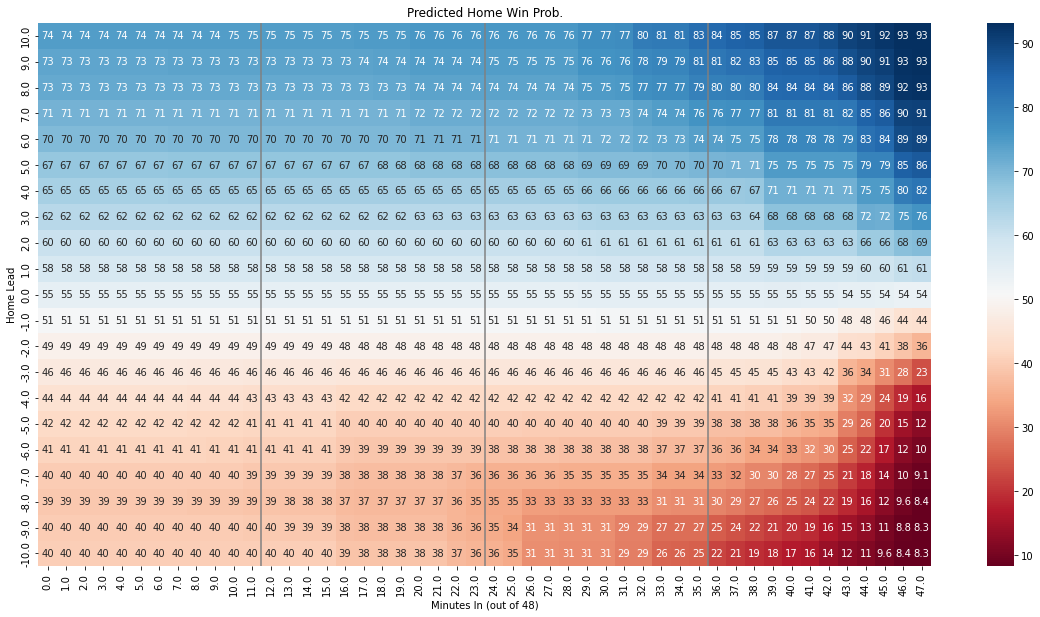

In [504]:
mins = np.arange(0, 48)
home_leads = np.arange(-10, 11)
dummy_data = pd.DataFrame(
    np.array([
        np.tile(.5, len(mins)*len(home_leads)),
        np.tile(.5, len(mins)*len(home_leads)),
        np.repeat(home_leads, len(mins)),
        np.tile(3.5, len(mins)*len(home_leads)),
        np.tile(3.5*mins, len(home_leads)),
        np.tile(mins, len(home_leads))
    ]).T,
    columns = ['home_wpct', 'vis_wpct', 'home_lead', 'ppm', 'total_points', 'mins']
)
dummy_data['yhat'] = mod.predict_proba(dummy_data)[:,1]
panel_ = dummy_data.pivot(index='home_lead', columns='mins', values='yhat')

fig, ax = plt.subplots(figsize=(20, 10))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
annot = True
sns.heatmap(panel_.loc[::-1, :]*100, annot=annot, cmap="RdBu")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");



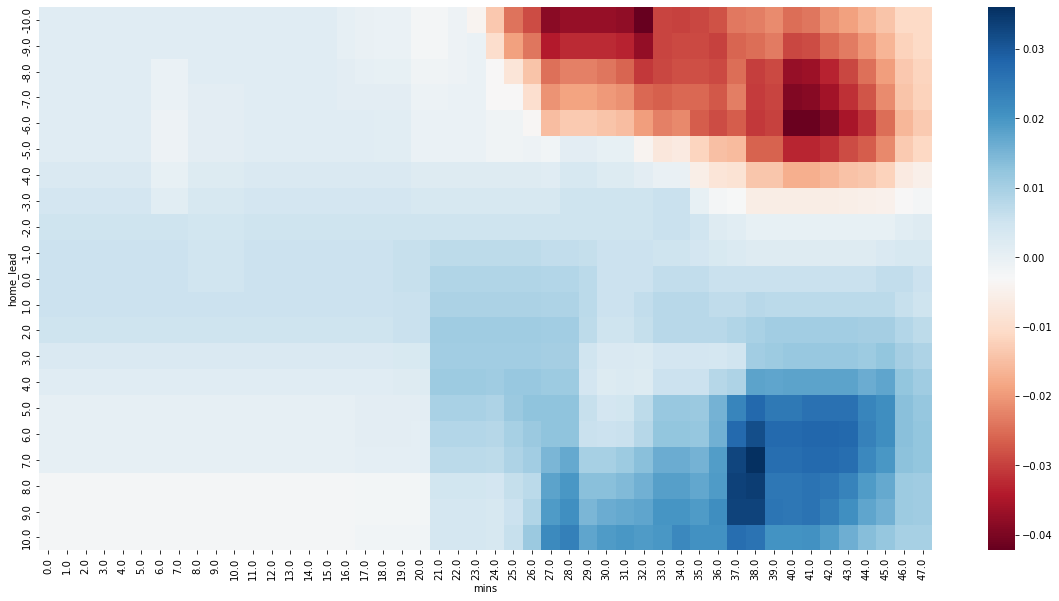

In [499]:
fig, ax = plt.subplots(figsize=(20, 10))
# sns.heatmap(panel - panel_, cmap="RdBu", vmin=-.05, vmax=.05);
sns.heatmap(panel - panel_, cmap="RdBu");


<BarContainer object of 6 artists>

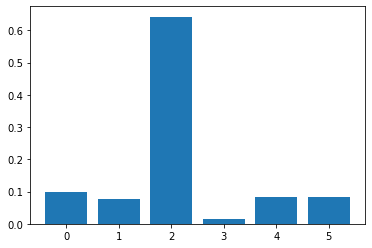

In [496]:
plt.bar(range(len(mod.feature_importances_)), mod.feature_importances_)
